# Quadrupolar Coupling Demo PULSEE

Jiwoo Seo, Ilija Nikolov, Alex Aoki

## Imports

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt

import pulsee.operators as op
import pulsee.plot as psplt
import pulsee.simulation as sim
from pulsee.pulses import Pulses

## Quantum System Setup

In [44]:
QUANTUM_NUMBER = 3 / 2  # Spin number
GAMMA_2PI = 1  # MHz/T
B0 = 1  # Tesla

B1 = 5e-1  # Tesla (strength of the pulse)

spin_par = {"quantum number": QUANTUM_NUMBER, "gamma/2pi": GAMMA_2PI}
zeem_par = {"field magnitude": B0, "theta_z": 0, "phi_z": 0}  # Zeeman parameter

pulse_time = 2 / (4 * 3 * GAMMA_2PI * B1)

In [45]:
e2qQ = 0.1  # MHz. Quadrupolar coupling constant
etas = np.linspace(0, 1, 2)  # Asymmetry parameter

## Simulation Function
Define simulation code which we will run with different solvers.

Refer to simple_90_pulse_demo for more details on setup and evolution.

In [46]:
h_unperturbed = None
spin = None

In [47]:
T2 = 600  # microS
ACQ_TIME = 1800  # microS
N_POINTS_EVOLVE = 1000
N_POINTS_FID = 20000


def simulate(solver):
    global h_unperturbed
    global spin
    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {
            "coupling constant": e2qQ,
            "asymmetry parameter": eta,
            "alpha_q": 0.0,
            "beta_q": np.pi / 2.0,
            "gamma_q": 0.0,
            "order": 0,
        }
        mode = Pulses(
            frequencies=[B0 * GAMMA_2PI],
            amplitudes=[B1],
            phases=[0],
            theta_p=[np.pi / 2],
            phi_p=[0],
            pulse_times=[pulse_time],
        )

        spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(
            spin_par, quad_par=quad_par, zeem_par=zeem_par, temperature=1e-5
        )

        print("Initial_state:")
        psplt.plot_real_part_density_matrix(dm_initial)
        opts = {"atol": 1e-16, "rtol": 1e-16}
        dm_evolved = sim.evolve(
            spin,
            h_unperturbed,
            dm_initial,
            solver=solver,
            mode=mode,
            picture="RRF",
            n_points=N_POINTS_EVOLVE,
            opts=opts,
            order=1,
        )

        print("Evolved_state:")
        psplt.plot_real_part_density_matrix(dm_evolved)
        t, FID = sim.FID_signal(
            spin, h_unperturbed, dm_evolved, acquisition_time=1800, T2=600, ref_freq=0, n_points=N_POINTS_FID, opts=opts
        )

        f, ft = sim.fourier_transform_signal(FID, t, padding=2)
        fts.append([eta, f, ft, t, FID])
    return fts

## Running the Simulation with Three Methods:
1. Magnus solver, which uses the analytical Magnus expansion
2. The 'mesolve' method using the QuTiP's time evolution functions which uses ODE integration of the time-dependent Hamiltonian
3. 


### Evolution and Plotting Results with Magnus solver

Initial_state:


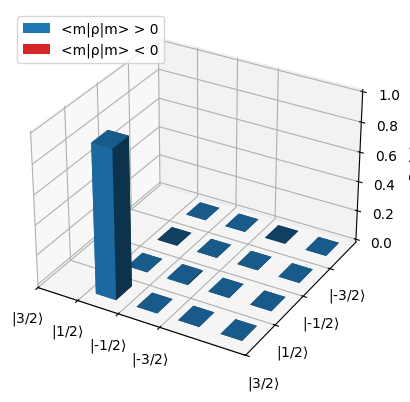

Evolved_state:


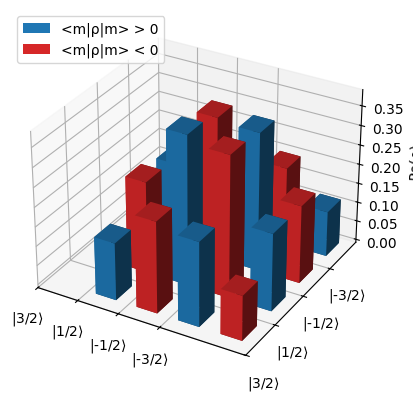

  0%|          | 0/19999 [00:00<?, ?it/s]

Initial_state:


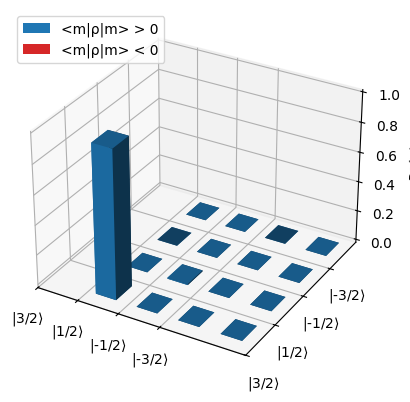

Evolved_state:


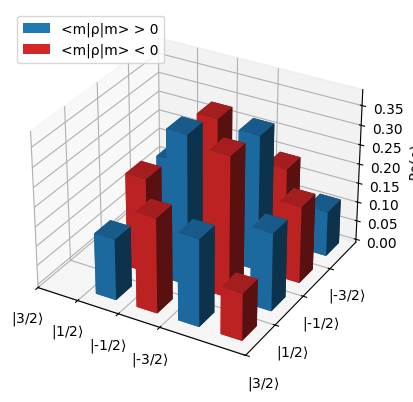

  0%|          | 0/19999 [00:00<?, ?it/s]

In [48]:
fts_magnus = simulate("magnus")

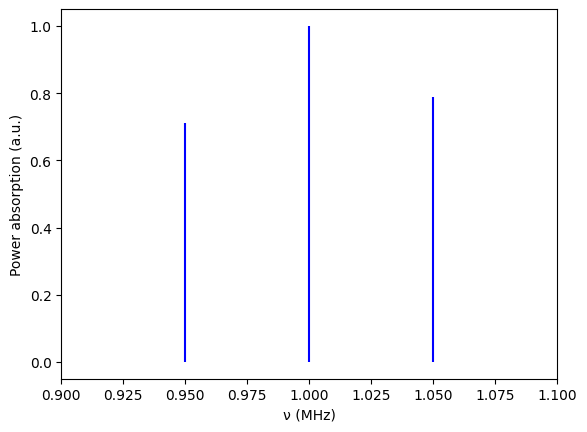

In [49]:
# Theoretically calculated where the expected transitions should be using the Fermi golden rule
f, p = sim.power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = psplt.plot_power_absorption_spectrum(f, p, xlim=(0.9, 1.1))

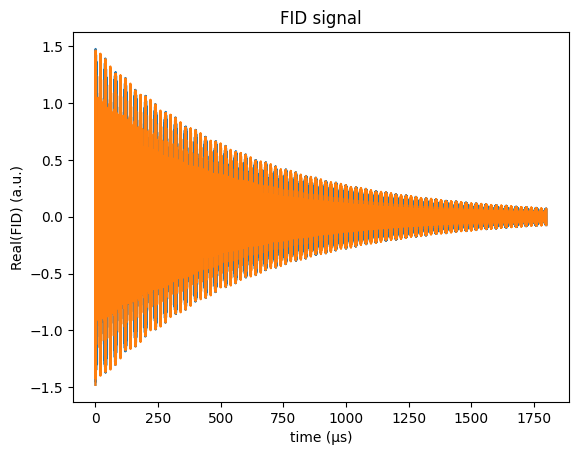

In [50]:
fig, ax = plt.subplots()
for (
    eta,
    f,
    ft,
    t,
    fid,
) in fts_magnus:
    psplt.plot_real_part_FID_signal(t, fid, figure=(fig, ax), show=False)
plt.show()

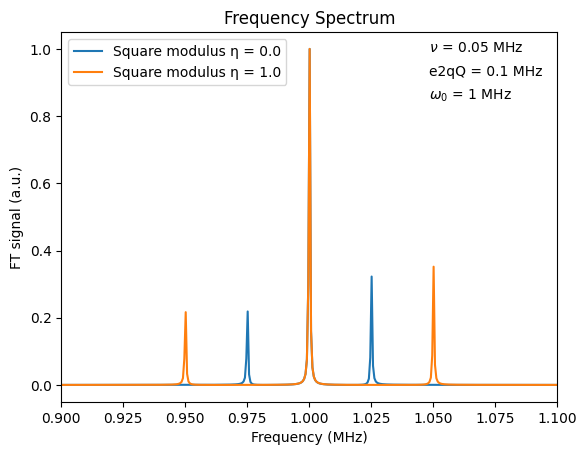

In [51]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_magnus:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(
        f, ft, square_modulus=True, xlim=(0.9, 1.1), figure=(fig, ax), my_label=label, show=False
    )

plt.figtext(0.7, 0.79, "e2qQ = " + str(np.round(e2qQ, 3)) + " MHz")
plt.figtext(0.7, 0.84, r"$\nu$ = " + str(np.round(e2qQ / 2, 3)) + " MHz")
plt.figtext(0.7, 0.74, r"$\omega_0$ = " + str(np.round(GAMMA_2PI * B0, 3)) + " MHz")
plt.show()

### Evolution and Plotting Results with Magnus solver

Initial_state:


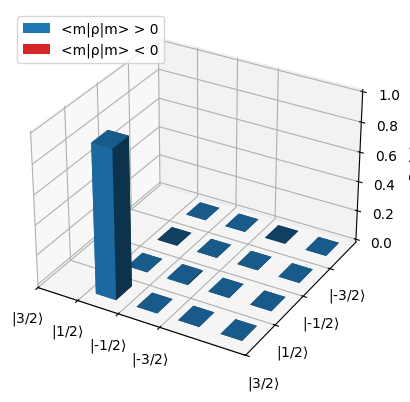

  0%|          | 0/999 [00:00<?, ?it/s]

Evolved_state:


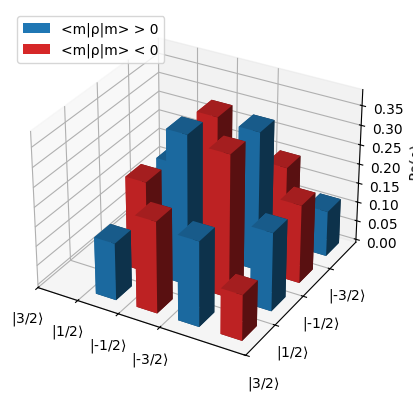

  0%|          | 0/19999 [00:00<?, ?it/s]

Initial_state:


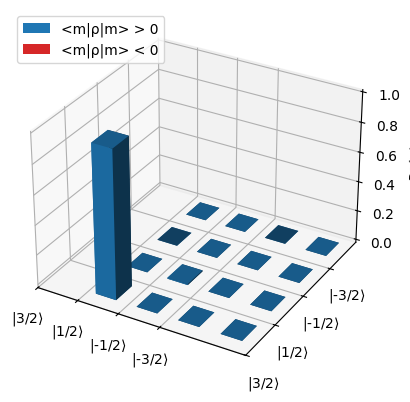

  0%|          | 0/999 [00:00<?, ?it/s]

Evolved_state:


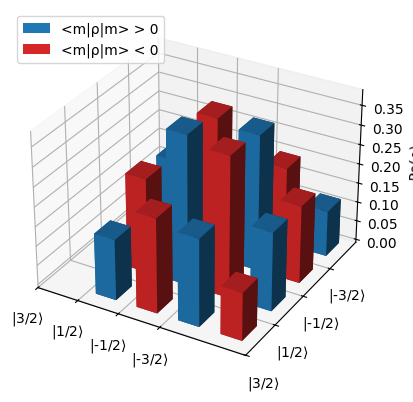

  0%|          | 0/19999 [00:00<?, ?it/s]

In [52]:
fts_mesolve = simulate("mesolve")

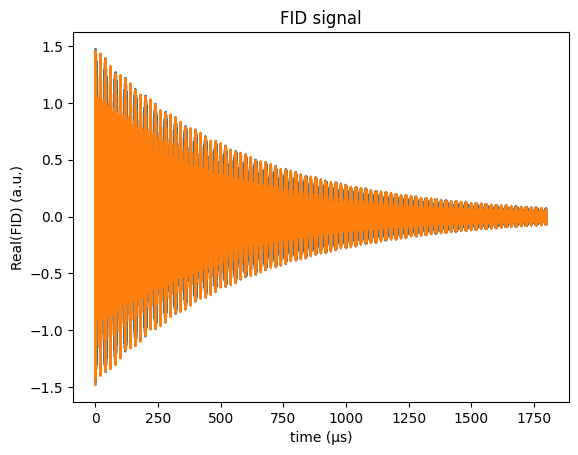

In [53]:
fig, ax = plt.subplots()
for (
    eta,
    f,
    ft,
    t,
    fid,
) in fts_mesolve:
    psplt.plot_real_part_FID_signal(t, fid, figure=(fig, ax), show=False)
plt.show()

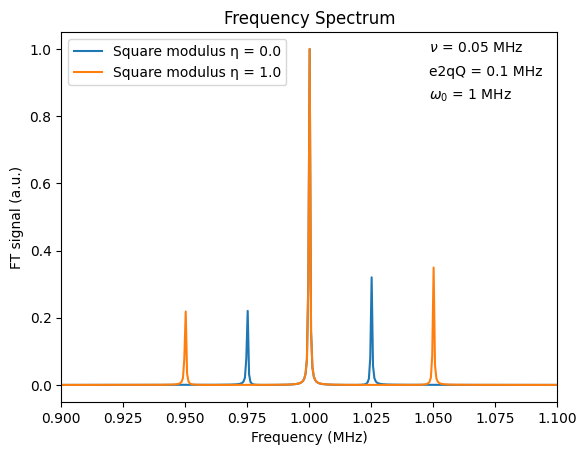

In [54]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_mesolve:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(
        f, ft, square_modulus=True, xlim=(0.9, 1.1), figure=(fig, ax), my_label=label, show=False
    )

plt.figtext(0.7, 0.79, "e2qQ = " + str(np.round(e2qQ, 3)) + " MHz")
plt.figtext(0.7, 0.84, r"$\nu$ = " + str(np.round(e2qQ / 2, 3)) + " MHz")
plt.figtext(0.7, 0.74, r"$\omega_0$ = " + str(np.round(GAMMA_2PI * B0, 3)) + " MHz")
plt.show()

One must experiment with the pulse duration to find the exact $\pi/2$ pulse. This is hard because of the presence of the Zeeman term in the Hamiltonian. The spins are rotating during the evolution of the pulse with respect to the applied field. This is why the peaks for the $\eta = 0$ case are not exactly symmetric.

### Evolution and Plotting Results with Exact Diagonalization

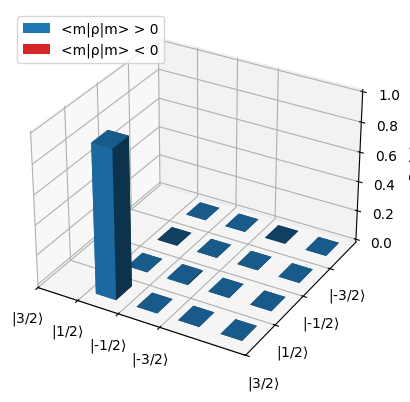

100%|██████████| 4000/4000 [00:00<00:00, 276568.79it/s]


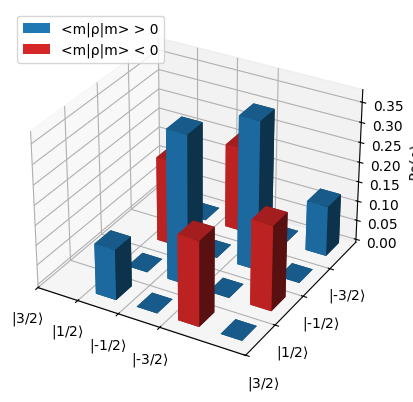

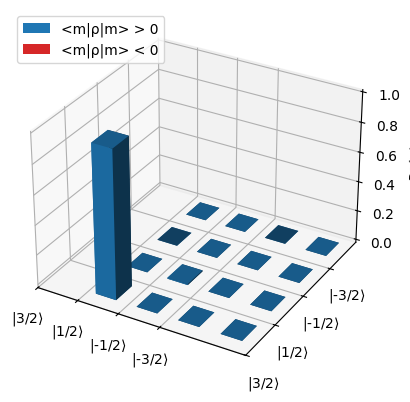

100%|██████████| 4000/4000 [00:00<00:00, 299224.46it/s]


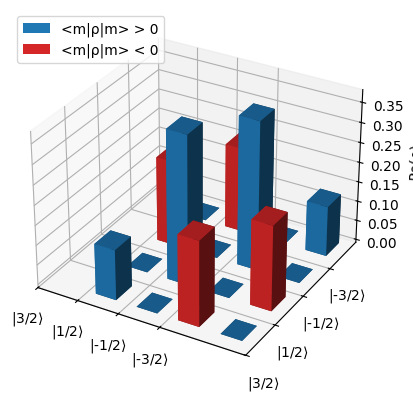

In [55]:
fts_ed = []

for eta in etas:
    quad_par = {
        "coupling constant": e2qQ,
        "asymmetry parameter": eta,
        "alpha_q": 0.0,
        "beta_q": np.pi / 2,
        "gamma_q": 0.0,
        "order": 0,
    }

    spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(
        spin_par, quad_par=quad_par, zeem_par=zeem_par, temperature=1e-5
    )

    psplt.plot_real_part_density_matrix(dm_initial)
    t = np.linspace(0, 800, 5 * 800)

    iz, ix, iy = (spin.I["z"], spin.I["x"], spin.I["y"])

    rot_dm = op.apply_rot_pulse(dm_initial, np.pi / 2, ix)  # rotate about x-axis
    dm_evolved, e_ops = sim.ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, parallel=False, T2=100)
    fig = psplt.plot_real_part_density_matrix(dm_evolved)
    FID = e_ops[0]

    f, ft = sim.fourier_transform_signal(FID, t, padding=0)
    fts_ed.append([eta, f, ft, t, FID])

Plot exact diagnalization solution:

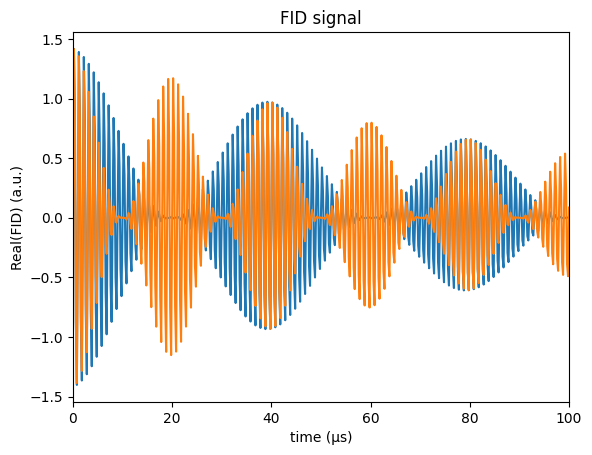

In [56]:
fig, ax = plt.subplots()
for (
    eta,
    f,
    ft,
    t,
    fid,
) in fts_ed:
    psplt.plot_real_part_FID_signal(t, fid, figure=(fig, ax), show=False, xlim=(0, 100))
plt.show()

Because of the idealized Ix pulse, exact diagonalization cannot exactly simulate experiments.

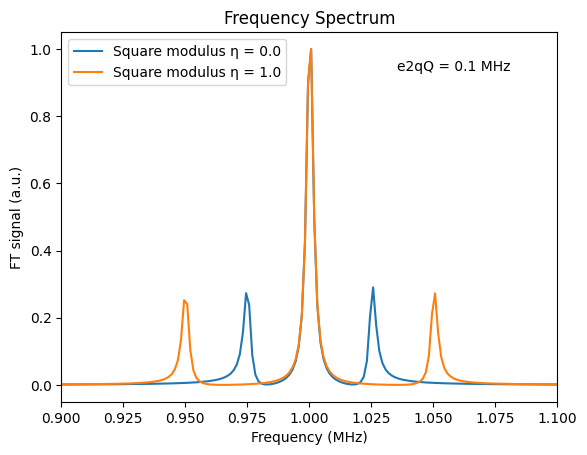

In [57]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_ed:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(
        f, ft, square_modulus=True, xlim=(0.9, 1.1), figure=(fig, ax), my_label=label, show=False
    )

plt.figtext(0.65, 0.8, "e2qQ = " + str(np.round(e2qQ, 3)) + " MHz")
plt.show()

Because of the instantaneous pulse, we have an exact $\pi/2$ pulse and the peaks for the $\eta = 0$ case are symmetric around the central peak.

Simulate with exact diagonalization approach & 2 different stretched exponential decays:

In [58]:
fts_ed = []

for eta in etas:
    quad_par = {
        "coupling constant": e2qQ,
        "asymmetry parameter": eta,
        "alpha_q": 0.0,
        "beta_q": np.pi / 2,
        "gamma_q": 0.0,
        "order": 0,
    }

    spin, h_unperturbed, dm_initial = sim.nuclear_system_setup(
        spin_par, quad_par=quad_par, zeem_par=zeem_par, initial_state="canonical", temperature=1e-5
    )

    t = np.linspace(0, 800, 5 * 800)  # 50 second acquisition time, 1000 data points

    ix, iy, iz = qt.spin_J_set(3 / 2)
    rot_dm = op.apply_rot_pulse(dm_initial, np.pi / 2, ix)  # rotate about x-axis
    dm_evolved, e_ops = sim.ed_evolve(
        h_unperturbed,
        rot_dm,
        spin,
        t,
        fid=True,
        parallel=False,
        T2=[lambda t: np.exp(-((t / 100) ** 1.5)), lambda t: np.exp(-((t / 100) ** 2))],
    )
    FID = e_ops[0]

    f, ft = sim.fourier_transform_signal(FID, t, padding=0)
    fts_ed.append([eta, f, ft, t, FID])

100%|██████████| 4000/4000 [00:00<00:00, 196463.72it/s]


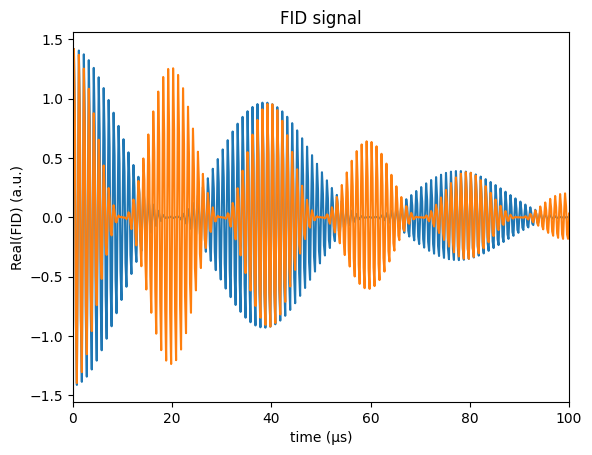

In [59]:
fig, ax = plt.subplots()
for (
    eta,
    f,
    ft,
    t,
    fid,
) in fts_ed:
    psplt.plot_real_part_FID_signal(t, fid, figure=(fig, ax), show=False, xlim=(0, 100))
plt.show()

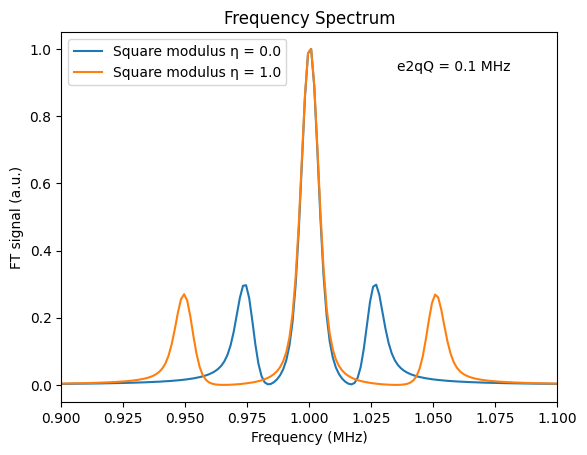

In [60]:
fig, ax = plt.subplots()

for eta, f, ft, t, fid in fts_ed:
    label = "\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2))
    fig, [ax] = psplt.plot_fourier_transform(
        f, ft, square_modulus=True, xlim=(0.9, 1.1), figure=(fig, ax), my_label=label, show=False
    )

plt.figtext(0.65, 0.8, "e2qQ = " + str(np.round(e2qQ, 3)) + " MHz")
plt.show()

The peaks are broadened here by two stretched exponentials exp($-(t/T_{2})^{\beta}$), where $T_{2} = 100\mu s$ and $\beta = {1.5,2}$.